In [35]:
import os.path as op
import pickle
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap
from scipy.stats import spearmanr, linregress
from joblib import Parallel, delayed
from statsmodels.stats.multitest import fdrcorrection

In [36]:
pipeline='NEARICA_behav'
epoch_types=['eye','task']
excluded_subjects=np.array(['C34','C36'])
left_handers=np.array(['C13','C20','C23','C40','C43','C46'])
min_trials_per_cond=10

In [37]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')

typ_color=np.array([27,158,119])/255.0
dcd_color=np.array([117,112,179])/255.0

In [38]:
exclude_typ=[]

all_bursts={
    'subject': [],
    'group': [],
    'epoch_type': [],
    'condition': [],
    'hemi': [],
    'cluster': [],
    'trial': [],
    'waveform': np.zeros((0,130)),
    'waveform_times': [],
    'peak_freq': [],
    'peak_amp_iter': [],
    'peak_amp_base': [],
    'peak_time': [],
    'peak_adjustment': [],
    'fwhm_freq': [],
    'fwhm_time': [],
    'polarity': [],
}

subjects = pd.read_csv('/home/bonaiuto/dcd_ross/data/participants.tsv', sep='\t')
df, meta = pyreadstat.read_sav('/home/bonaiuto/dcd_ross/CoMB_Dataset.sav')

subject_ids = subjects['participant_id']
for subj_id in subject_ids:
    group=df['Group'][np.where(df['SubjectID']==subj_id)[0]].values[0]
    mab_per=df['MABC_Percentile'][np.where(df['SubjectID']==subj_id)[0]].values[0]        
    if group==0 and mab_per<25:
        exclude_typ.append(subj_id)
        
    if not len(np.where(excluded_subjects==subj_id)[0]):
        subject_data_dir=op.join('/home/bonaiuto/dcd_ross/data/derivatives', pipeline, subj_id, 'processed_data')
        for epoch_type in epoch_types:
            for cluster in ['C3','C4']:
                if cluster=='C3':
                    if np.isin(subj_id,left_handers):
                        hemi='ipsi'
                    else:
                        hemi='contra'
                else:
                    if np.isin(subj_id,left_handers):
                        hemi='contra'
                    else:
                        hemi='ipsi'
                fname=op.join(subject_data_dir, f'bursts_{subj_id}_{epoch_type}_{cluster}.pickle')
                if op.exists(fname):
                    with open(fname,'rb') as file:
                        bursts=pickle.load(file)
                    n_bursts=len(bursts['trial'])
                    bursts['group']=np.array([group for i in range(n_bursts)])
                    bursts['hemi']=np.array([hemi for i in range(n_bursts)])
                    bursts['cluster']=np.array([cluster for i in range(n_bursts)])
                    for key in bursts.keys():
                        if key=='waveform_times':
                            all_bursts[key] = bursts[key]
                        elif key=='waveform':
                            all_bursts[key] = np.vstack([all_bursts[key], bursts[key]])
                        else:
                            all_bursts[key] = np.hstack([all_bursts[key], bursts[key]])
    else:
        print(f'skipping {subj_id}')

skipping C34
skipping C36


In [39]:
print('Excluded because of low MABC percentile')
print(exclude_typ)

Excluded because of low MABC percentile
['C06', 'C07', 'C08', 'C31', 'C32', 'C35', 'C39', 'C55', 'C58']


In [40]:
include_typ_idx = ~np.isin(all_bursts['subject'], exclude_typ)
typ_idx=np.where(include_typ_idx & (all_bursts['group']==0))[0]
dcd_idx=np.where(all_bursts['group']==1)[0]

In [41]:
print(np.unique(all_bursts['subject'][typ_idx]))
print(np.unique(all_bursts['subject'][dcd_idx]))

['C03' 'C04' 'C05' 'C09' 'C14' 'C18' 'C21' 'C22' 'C23' 'C24' 'C29' 'C30'
 'C38' 'C41' 'C42' 'C45' 'C47' 'C48' 'C50' 'C51' 'C52' 'C53' 'C54' 'C57']
['C10' 'C11' 'C12' 'C13' 'C15' 'C16' 'C17' 'C19' 'C20' 'C25' 'C26' 'C27'
 'C28' 'C33' 'C37' 'C40' 'C43' 'C44' 'C46' 'C49' 'C56']


In [42]:
n_typ=len(np.unique(all_bursts['subject'][typ_idx]))
n_dcd=len(np.unique(all_bursts['subject'][dcd_idx]))
print(f'N typical={n_typ}')
print(f'N DCD={n_dcd}')

N typical=24
N DCD=21


In [43]:
burst_times=all_bursts['waveform_times']
typ_pca = PCA(n_components=20)
typ_burst_std=RobustScaler().fit_transform(all_bursts['waveform'][typ_idx,:])
typ_pca=typ_pca.fit(typ_burst_std)

dcd_pca = PCA(n_components=20)
dcd_burst_std=RobustScaler().fit_transform(all_bursts['waveform'][dcd_idx,:])
dcd_pca=dcd_pca.fit(dcd_burst_std)

def spearman_correlation_matrix(pca1, pca2):
    eigenvectors1 = pca1.components_.T
    eigenvectors2 = pca2.components_.T
    n_components = eigenvectors1.shape[1]
    
    corr_matrix = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(n_components):
            corr, _ = spearmanr(eigenvectors1[:, i], eigenvectors2[:, j])
            corr_matrix[i, j] = abs(corr)  # Absolute value of the Spearman correlation
    return corr_matrix

pca_corr_matrix = spearman_correlation_matrix(typ_pca, dcd_pca)
max_corrs=[]
for i in range(pca_corr_matrix.shape[0]):
    max_corrs.append(np.max(pca_corr_matrix[i,:]))
print(f'min={np.min(max_corrs)}, max={np.max(max_corrs)}')


min=0.6775539745182919, max=0.9995193161179313


In [111]:
max_corrs

[0.9995193161179313,
 0.9916918160837919,
 0.9927023446995041,
 0.9944338991383195,
 0.9955973726255991,
 0.9934998429583907,
 0.7214273033907332,
 0.6775539745182919,
 0.9956738450613826,
 0.970284996381215,
 0.9762279971049721,
 0.9790083163773914,
 0.9624738832976005,
 0.8529325813543815,
 0.8165480888718949,
 0.9255868576656788,
 0.9580384820221497,
 0.9362711494080214,
 0.9600595392535743,
 0.9253355910909613]

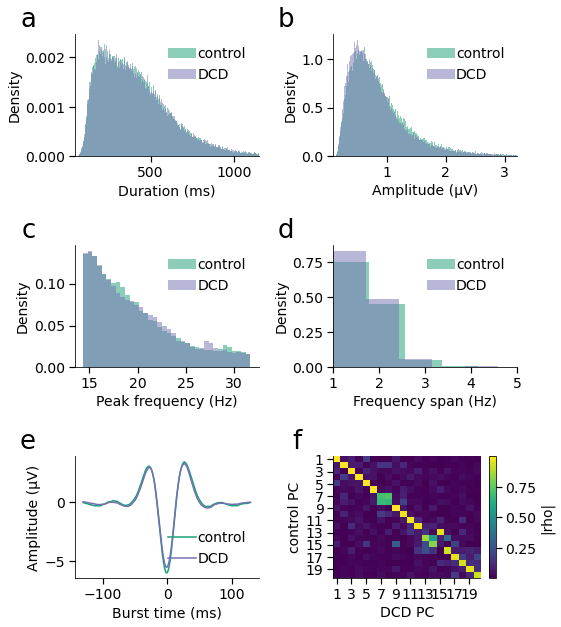

In [85]:
plt.figure(figsize=(8,9))
ax=plt.subplot(3,2,1)
plt.hist(
    all_bursts['fwhm_time'][typ_idx]*1000,
    1125,
    alpha=.5,
    label='control',
    density=True,
    color=typ_color
)
plt.hist(
    all_bursts['fwhm_time'][dcd_idx]*1000,
    935,
    alpha=.5,
    label='DCD',
    density=True,
    color=dcd_color
)
plt.legend()
plt.xlim(np.percentile(all_bursts['fwhm_time']*1000,[0,99]))
plt.ylabel('Density')
plt.xlabel('Duration (ms)')
add_subplot_label(ax, 'a')

ax=plt.subplot(3,2,2)
plt.hist(
    all_bursts['peak_amp_base'][typ_idx]*1e6,
    1000,
    alpha=.5,
    label='control',
    density=True, 
    color=typ_color
)
plt.hist(
    all_bursts['peak_amp_base'][dcd_idx]*1e6,
    1000,
    alpha=.5,
    label='DCD',
    density=True,
    color=dcd_color
)
plt.legend()
plt.xlim(np.percentile(all_bursts['peak_amp_base']*1e6,[0,99]))
plt.ylabel('Density')
plt.xlabel('Amplitude (µV)')
add_subplot_label(ax, 'b')

ax=plt.subplot(3,2,3)   
plt.hist(
    all_bursts['peak_freq'][typ_idx],
    36,
    alpha=.5,
    label='control',
    density=True, 
    color=typ_color
)
plt.hist(
    all_bursts['peak_freq'][dcd_idx],
    36,
    alpha=.5,
    label='DCD',
    density=True,
    color=dcd_color
)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Peak frequency (Hz)')
add_subplot_label(ax, 'c')

ax=plt.subplot(3,2,4)
plt.hist(
    all_bursts['fwhm_freq'][typ_idx],
    15,
    alpha=.5,
    label='control',
    density=True, 
    color=typ_color
)
plt.hist(
    all_bursts['fwhm_freq'][dcd_idx],
    11,
    alpha=.5,
    label='DCD',
    density=True,
    color=dcd_color
)
plt.legend()
plt.xlim([1,5])
plt.ylabel('Density')
plt.xlabel('Frequency span (Hz)')
add_subplot_label(ax, 'd')

ax=plt.subplot(3,2,5)
plt.plot(
    all_bursts['waveform_times']*1000, 
    np.median(all_bursts['waveform'][typ_idx,:],axis=0)*1e6,
    label='control', 
    color=typ_color
)
plt.plot(
    all_bursts['waveform_times']*1000, 
    np.median(all_bursts['waveform'][dcd_idx,:],axis=0)*1e6,
    label='DCD',
    color=dcd_color
)
plt.legend()
plt.xlabel('Burst time (ms)')
plt.ylabel('Amplitude (µV)')
add_subplot_label(ax, 'e')

ax=plt.subplot(3,2,6)
im=ax.imshow(pca_corr_matrix, cmap='viridis', aspect='auto')
plt.colorbar(im, label="|rho|")
ax.set_xlabel('DCD PC')
ax.set_ylabel('control PC')
ax.set_xticks(np.arange(0,20,2))
ax.set_xticklabels(np.arange(0,20,2)+1)
ax.set_yticks(np.arange(0,20,2))
ax.set_yticklabels(np.arange(0,20,2)+1)
add_subplot_label(ax, 'f')

plt.tight_layout()

plt.savefig('./manuscript/fig2_burst_feature_comparison.pdf',dpi=600)

In [86]:
def permutation_test(data1, data2, n_permutations=100000):
    # Observed difference in means
    obs_diff = np.nanmean(data1) - np.nanmean(data2)
    
    # Combine data and shuffle labels
    combined_data = np.concatenate([data1, data2])
    n1 = len(data1)
    
    # Permutation test
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined_data)
        perm_diff = np.nanmean(combined_data[:n1]) - np.nanmean(combined_data[n1:])
        perm_diffs.append(perm_diff)
    
    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.nanmean(np.abs(perm_diffs) >= np.abs(obs_diff))
    return obs_diff, p_value

def paired_permutation_test(data1, data2, n_permutations=100000):
    """
    Performs a paired permutation test to evaluate the significance of the difference between two dependent samples.
    
    Parameters:
        data1 (array-like): First set of paired observations.
        data2 (array-like): Second set of paired observations.
        n_permutations (int): Number of permutations to perform.
    
    Returns:
        tuple: (observed difference, p-value)
    """
    # Compute observed difference in means
    diffs = np.array(data1) - np.array(data2)
    obs_diff = np.nanmean(diffs)
    
    # Perform permutations by randomly flipping signs
    perm_diffs = []
    for _ in range(n_permutations):
        sign_flips = np.random.choice([-1, 1], size=len(diffs), replace=True)
        perm_diff = np.nanmean(diffs * sign_flips)
        perm_diffs.append(perm_diff)
    
    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.nanmean(np.abs(perm_diffs) >= np.abs(obs_diff))
    
    return obs_diff, p_value

def analyze_burst_rate(condition_labels, condition_events, trial_dur, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'][np.where(include_typ_idx)[0]])
    typ_subj = np.unique(all_bursts['subject'][np.where(include_typ_idx & (all_bursts['group'] == 0))[0]])
    dcd_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 1)[0]])

    time_bin_size = .1
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    condition_rates_unsmoothed = {}
    condition_subjects = {}
    for cond in condition_labels:
        condition_rates_unsmoothed[cond] = {'typ': [], 'dcd': []}
        condition_subjects[cond] = {'typ': [], 'dcd': []}
    
    for subject in subjects:
        group_val = np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0]
        group = 'typ' if group_val == 0 else 'dcd'
        subj_idx = (all_bursts['subject'] == subject)

        for cond, event in zip(condition_labels, condition_events):
            cond_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == event)])
            base_trials = []
            if baseline_evt is not None:
                base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)])
            if len(cond_trials) >= min_trials_per_cond and (baseline_evt is None or len(base_trials) >= min_trials_per_cond):
                unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == event)], bins=time_bins)
                unsmoothed_rate = (unsmoothed_rate * (1 / time_bin_size)) / len(cond_trials)
                if baseline_evt is not None:
                    unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == baseline_evt)], bins=time_bins)
                    unsmoothed_base_rate = (unsmoothed_base_rate * (1 / time_bin_size)) / len(base_trials)
                    unsmoothed_mbase_rate = np.mean(unsmoothed_base_rate)
                    unsmoothed_bc_rate = (unsmoothed_rate - unsmoothed_mbase_rate) / unsmoothed_mbase_rate * 100
                    condition_rates_unsmoothed[cond][group].append(unsmoothed_bc_rate)
                else:
                    condition_rates_unsmoothed[cond][group].append(unsmoothed_rate)
                condition_subjects[cond][group].append(subject)

    time_bins = time_bins[:-1]
    
    # Prepare data for permutation tests
    perm_results = []
    for cond in condition_rates_unsmoothed:
        for group in ['typ', 'dcd']:
            rates = np.vstack(condition_rates_unsmoothed[cond][group])
            avg_rates = np.mean(rates, axis=1)
            subj_ids = np.array(condition_subjects[cond][group])

            mean_val = np.nanmean(avg_rates)
            std_val = np.nanstd(avg_rates)
            keep_idx = (avg_rates > mean_val - 2.5 * std_val) & (avg_rates < mean_val + 2.5 * std_val)

            outlier_subjects = subj_ids[~keep_idx]
            if len(outlier_subjects) > 0:
                print(f"Outliers in {cond} {group}: {outlier_subjects}")

            condition_rates_unsmoothed[cond][group] = rates[keep_idx, :]

        # Average burst rate over time for permutation test
        avg_rate_typ = np.mean(condition_rates_unsmoothed[cond]['typ'], axis=1)
        avg_rate_dcd = np.mean(condition_rates_unsmoothed[cond]['dcd'], axis=1)

        # Perform permutation test
        diff, p_value = permutation_test(avg_rate_typ, avg_rate_dcd)
        perm_results.append((cond, diff, p_value))
        print(f"Condition {cond}: Mean Diff = {diff:.3f}, p-value = {p_value:.3f}")


In [87]:
typ_subjects=np.unique(all_bursts['subject'][typ_idx])
dcd_subjects=np.unique(all_bursts['subject'][dcd_idx])
tf_features=['fwhm_time','peak_amp_base','peak_freq','fwhm_freq']
subj_burst_features={}
for feature in tf_features:
    subj_burst_features[feature]={'typ': [], 'dcd': []}

for subject in typ_subjects:
    for feature in tf_features:
        mean_val=np.mean(all_bursts[feature][all_bursts['subject']==subject])
        subj_burst_features[feature]['typ'].append(mean_val)

for subject in dcd_subjects:
    for feature in tf_features:
        mean_val=np.mean(all_bursts[feature][all_bursts['subject']==subject])
        subj_burst_features[feature]['dcd'].append(mean_val)
        
for feature in tf_features:
    typ_mean=np.mean(subj_burst_features[feature]['typ'])
    typ_sd=np.std(subj_burst_features[feature]['typ'])
    dcd_mean=np.mean(subj_burst_features[feature]['dcd'])
    dcd_sd=np.std(subj_burst_features[feature]['dcd'])
    obs_diff, p_value=permutation_test(subj_burst_features[feature]['typ'], subj_burst_features[feature]['dcd'])
    print(f'{feature} Mtyp={typ_mean}, SD={typ_sd}, Mdcd={dcd_mean}, SD={dcd_sd}, p={p_value}')

fwhm_time Mtyp=0.4200346105607904, SD=0.049206829930578996, Mdcd=0.4199146186858262, SD=0.05639677610684895, p=0.99364
peak_amp_base Mtyp=9.536728558479298e-07, SD=3.21234715817132e-07, Mdcd=9.469888868932217e-07, SD=4.993307400863598e-07, p=0.96264
peak_freq Mtyp=19.575512214197808, SD=1.1160082979450434, Mdcd=19.749637418111906, SD=1.4105984843928336, p=0.65667
fwhm_freq Mtyp=1.4692180439450144, SD=0.09854494734415895, Mdcd=1.459573134316444, SD=0.12134720380212832, p=0.77699


In [88]:
analyze_burst_rate(['kaleidoscope'], ['E  9'], 10)

Condition kaleidoscope: Mean Diff = -0.033, p-value = 0.818


In [89]:
analyze_burst_rate(['obs fine', 'obs gross'], ['E 17', 'E 18'], 10, baseline_evt='E  9')

Condition obs fine: Mean Diff = 0.497, p-value = 0.705
Condition obs gross: Mean Diff = -1.811, p-value = 0.153


In [90]:
analyze_burst_rate(['exe fine', 'exe gross'], ['E 33', 'E 34'], 10, baseline_evt='E  9')

Outliers in exe fine dcd: ['C44']
Condition exe fine: Mean Diff = 1.719, p-value = 0.394
Outliers in exe gross typ: ['C09']
Condition exe gross: Mean Diff = 0.009, p-value = 0.996


In [91]:
burst_times=all_bursts['waveform_times']
pca = PCA(n_components=20)
burst_std=RobustScaler().fit_transform(all_bursts['waveform'])
pca=pca.fit(burst_std[include_typ_idx,:])
pcs = pca.transform(burst_std)


pca_components = pd.DataFrame(pcs)

In [92]:
cum_var_exp=np.cumsum(pca.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

7 components explain 81.63447549146503% of variance


In [93]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    print(n_comps*(1-results))
    PCS_to_analyse = np.where(results > threshold)[0]
    return PCS_to_analyse

In [94]:
shuffling_results=get_num_components(all_bursts['waveform'][include_typ_idx,:], 20)
print(f'Non-noise PCs: {shuffling_results}')

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20. 20. 20. 20. 20. 20. 20.
 20. 20.]
Non-noise PCs: [ 0  1  2  3  4  5  6  7  8  9 10]


In [95]:
conditions = ['obs fine', 'obs gross', 'exe fine', 'exe gross']
condition_evts = ['E 17', 'E 18', 'E 33', 'E 34']
pc_score_changes={}
subjects = np.unique(all_bursts['subject'][include_typ_idx])

all_score_changes=np.zeros((20,len(subjects)))

for pc_idx in range(20):
    for s_idx, subject in enumerate(subjects):
        b_idx = (all_bursts['condition']=='E  9') & (all_bursts['subject']==subject)
        mb_score = np.mean(pca_components[pc_idx][b_idx])
        c_idx = ((all_bursts['condition']=='E 17') | (all_bursts['condition']=='E 18') | (all_bursts['condition']=='E 33') | (all_bursts['condition']=='E 34')) & (all_bursts['subject']==subject)
        mc_score = np.mean(pca_components[pc_idx][c_idx])
        all_score_changes[pc_idx,s_idx]=np.abs(mc_score-mb_score)
        
        for cond, evt in zip(conditions, condition_evts):
            c_idx = (all_bursts['subject']==subject) & (all_bursts['condition']==evt)
            mc_score = np.mean(pca_components[pc_idx][c_idx])
            if not cond in pc_score_changes:
                pc_score_changes[cond]=np.zeros((20,len(subjects)))
            pc_score_changes[cond][pc_idx,s_idx]=np.abs(mc_score-mb_score)
all_score_changes=np.nanmean(all_score_changes,axis=-1)
for cond in conditions:
    pc_score_changes[cond]=np.nanmean(pc_score_changes[cond],axis=-1)

In [96]:
# Number of permutations
n_permutations = 1000

# Store permutation results
null_distributions = np.zeros((len(shuffling_results), n_permutations))

def permute(pc_idx, all_bursts, pca_components, subjects):
    permuted_scores = np.zeros(len(subjects))
    
    for s_idx, subject in enumerate(subjects):
        # Get indices for baseline and condition
        b_idx = (all_bursts['condition'] == 'E  9') & (all_bursts['subject'] == subject)
        c_idx = ((all_bursts['condition'] == 'E 17') | (all_bursts['condition'] == 'E 18') |
                 (all_bursts['condition'] == 'E 33') | (all_bursts['condition'] == 'E 34')) & \
                (all_bursts['subject'] == subject)
        
        # Collect the values
        mb_values = pca_components[pc_idx][b_idx]
        mc_values = pca_components[pc_idx][c_idx]
        
        # Combine and shuffle labels
        combined = np.concatenate((mb_values, mc_values))
        shuffled = np.random.permutation(combined)
        
        # Split into new baseline and condition
        mb_shuffled = np.mean(shuffled[:len(mb_values)])
        mc_shuffled = np.mean(shuffled[len(mb_values):])
        
        permuted_scores[s_idx] = np.abs(mc_shuffled - mb_shuffled)
    
    return np.nanmean(permuted_scores)

def permutation_iteration(_, all_bursts, pca_components, subjects):
    return np.array([permute(pc_idx, all_bursts, pca_components, subjects) for pc_idx in shuffling_results])

# Perform permutation test in parallel
results = Parallel(n_jobs=-1)(
    delayed(permutation_iteration)(_, all_bursts, pca_components, subjects)
    for _ in range(n_permutations)
)
null_distributions = np.array(results).T

# Compute significance threshold (e.g., 95th percentile)
thresholds = np.percentile(null_distributions, 95, axis=1)

# Compute p-values
p_values = np.mean(null_distributions >= all_score_changes[shuffling_results][:, np.newaxis], axis=1)

# Find significant components
modulated_pcs = shuffling_results[np.where((all_score_changes[shuffling_results] > thresholds))[0]]

# Print results
for idx, pc in enumerate(shuffling_results):
    print(f'PC {pc}: p-value = {p_values[idx]:.4f}')

print(f'Modulated PCs: {modulated_pcs}')

PC 0: p-value = 0.5910
PC 1: p-value = 0.2690
PC 2: p-value = 0.5610
PC 3: p-value = 0.0000
PC 4: p-value = 0.3450
PC 5: p-value = 0.0000
PC 6: p-value = 0.0000
PC 7: p-value = 0.0000
PC 8: p-value = 0.2510
PC 9: p-value = 0.0000
PC 10: p-value = 0.0000
Modulated PCs: [ 3  5  6  7  9 10]


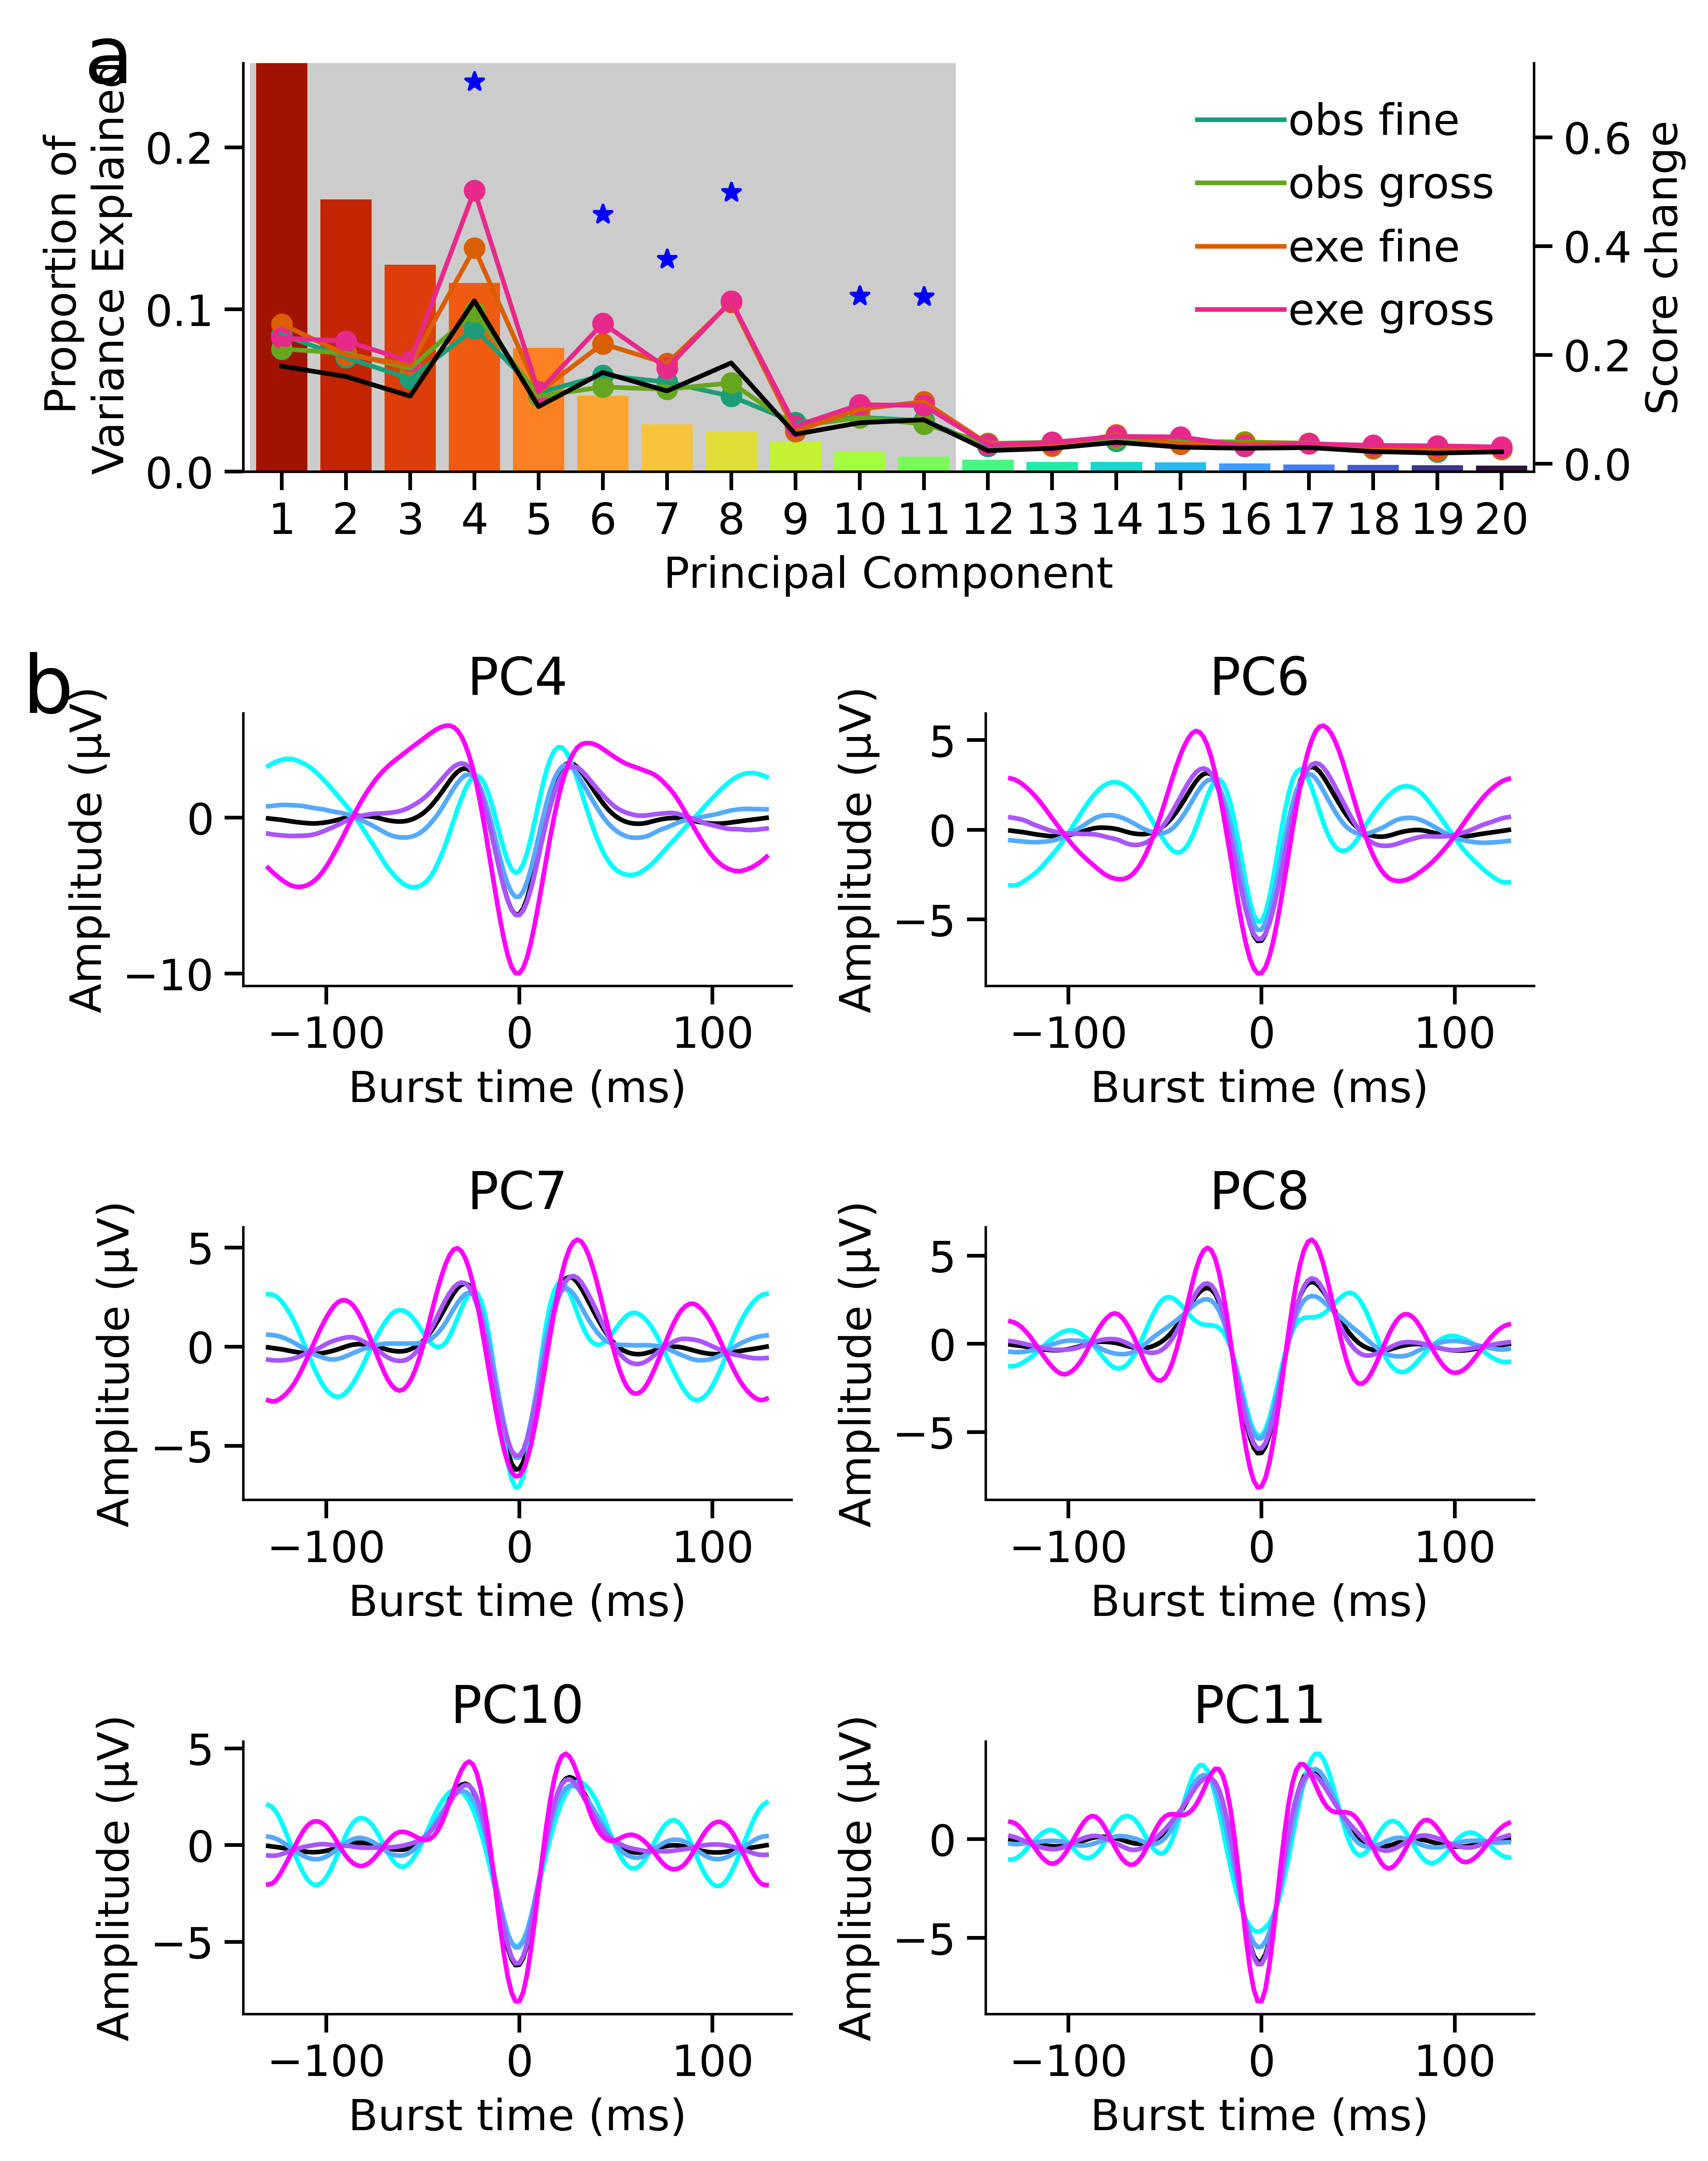

In [97]:
# Define colormap
col_r = plt.cm.cool(np.linspace(0, 1, num=4))

# Figure setup using GridSpec
fig = plt.figure(figsize=(8, 14), dpi=600, facecolor="white")
gs = GridSpec(6, 2, figure=fig, height_ratios=[1.5, 1, 1, 1, 1, 1])

# Top subplot: Variance explained plot
ax = fig.add_subplot(gs[0, :])  # Span all three columns
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': True,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
PC_var_exp = pca.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
shuf_plot=np.zeros(PC_var_exp.shape[0])
shuf_plot[shuffling_results]=np.max(PC_var_exp)
bar = ax.bar(PC_r, shuf_plot, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_ylim([0, PC_var_exp[0]])
_=ax.set_xticks(PC_r)
ax.set_xlim([.4,20.5])
ax2 = ax.twinx()

cmap = ListedColormap(plt.get_cmap("Dark2").colors[:5])
cond_colors = [cmap(0), cmap(4), cmap(1), cmap(3)]
for cond, color in zip(conditions, cond_colors):
    ax2.scatter(PC_r, pc_score_changes[cond], color=color)
    ax2.plot(PC_r, pc_score_changes[cond], label=cond, color=color)
ax2.plot(PC_r, all_score_changes, color='k')
ax2.scatter(modulated_pcs+1, pc_score_changes['exe gross'][modulated_pcs]+.2,marker='*',color='b')
ax2.set_ylabel("Score change")
plt.legend()
add_subplot_label(ax, 'a', x=-.085, y=1.1)
                  

plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

col_r = plt.cm.cool(np.linspace(0, 1, num=4))
m_waveform = np.mean(all_bursts['waveform'][include_typ_idx,:],axis=0)*1e6


# Lower subplots: Waveforms
for p_idx, pc_idx in enumerate(modulated_pcs):
    ax_waveform = fig.add_subplot(gs[1 + p_idx // 2, p_idx % 2])  # Grid for waveform subplots
    plt.plot(all_bursts['waveform_times']*1000, m_waveform, 'k')
    n_q=4
    step=100/n_q
    q_bins = np.percentile(pca_components[pc_idx], np.arange(0,100+step,step))
    for q in range(n_q):
        q_idx = include_typ_idx & (pca_components[pc_idx]>=q_bins[q]) & (pca_components[pc_idx]<=q_bins[q+1])
        q_waveform = np.mean(all_bursts['waveform'][q_idx,:],axis=0)*1e6
        ax_waveform.plot(all_bursts['waveform_times']*1000, q_waveform, color=col_r[q,:], label=f'Q{q+1}')
    ax_waveform.set_xlabel('Burst time (ms)')
    ax_waveform.set_ylabel('Amplitude (µV)')
    if p_idx==(len(shuffling_results)-1):
        plt.legend(loc='lower right')
    ax_waveform.set_title(f'PC{pc_idx + 1}')
    if p_idx==0:
        add_subplot_label(ax_waveform, 'b', x=-.31)
        
plt.tight_layout()
plt.savefig('./manuscript/fig3_pca.pdf', dpi=600)

In [100]:
n_pc_bins=4

def bootstrap_regression_ci(x, y, x_fit, num_bootstrap=10000, ci=95):
    """
    Compute confidence intervals for regression predictions using bootstrapping.
    """
    n = len(x)
    bootstrap_predictions = np.zeros((num_bootstrap, len(x_fit)))
    
    for i in range(num_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        slope, intercept, _, _, _ = linregress(x_sample, y_sample)
        bootstrap_predictions[i, :] = slope * x_fit + intercept

    lower_bound = (100 - ci) / 2
    upper_bound = 100 - lower_bound
    y_fit_lower = np.percentile(bootstrap_predictions, lower_bound, axis=0)
    y_fit_upper = np.percentile(bootstrap_predictions, upper_bound, axis=0)
    
    return y_fit_lower, y_fit_upper



def plot_pc_burst_rate(conditions, events, trial_dur, pc_idx, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'])
    step = 100 / n_pc_bins
    t_bins = np.percentile(pca_components[pc_idx], np.arange(0, 100 + step, step))
    time_bin_size = .05
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    t_rates_unsmoothed = {}
    avg_rates = {}
    perm_results = {}
    included_subjects = {
        condition: {t: {'typ': [], 'dcd': []} for t in range(n_pc_bins)}
        for condition in conditions
    }

    for condition in conditions:
        t_rates_unsmoothed[condition] = {}
        avg_rates[condition] = {}
        perm_results[condition] = []
        for t in range(n_pc_bins):
            t_rates_unsmoothed[condition][t] = {'typ': [], 'dcd': []}
            avg_rates[condition][t] = {'typ': [], 'dcd': []}

    for condition, event in zip(conditions, events):
        n_subjects = {'typ': 0, 'dcd': 0}
        for subject in subjects:
            if ~np.isin(subject, exclude_typ):
                group = 'typ' if np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0] == 0 else 'dcd'
                subj_idx = (all_bursts['subject'] == subject)
                cond_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == event)])
                base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)]) if baseline_evt else []

                if len(cond_trials) >= min_trials_per_cond and (baseline_evt is None or len(base_trials) >= min_trials_per_cond):
                    n_subjects[group] += 1
                    for t in range(n_pc_bins):
                        t_idx = (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t+1])

                        rate_mask = subj_idx & (all_bursts['condition'] == event) & t_idx
                        unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][rate_mask], bins=time_bins)
                        unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                        if baseline_evt:
                            base_mask = subj_idx & (all_bursts['condition'] == baseline_evt) & t_idx
                            unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][base_mask], bins=time_bins)
                            unsmoothed_base_rate = (unsmoothed_base_rate / time_bin_size) / len(base_trials)
                            unsmoothed_bc_rate = (unsmoothed_rate - np.mean(unsmoothed_base_rate)) / np.mean(unsmoothed_base_rate) * 100
                            t_rates_unsmoothed[condition][t][group].append(unsmoothed_bc_rate)
                        else:
                            t_rates_unsmoothed[condition][t][group].append(unsmoothed_rate)

                        included_subjects[condition][t][group].append(subject)
                else:
                    print(f'{condition}: {subject} - not enough trials')
        print(f'{condition}: {n_subjects}')

        for t in t_rates_unsmoothed[condition]:
            for group in ['typ', 'dcd']:
                t_matrix = np.vstack(t_rates_unsmoothed[condition][t][group])
                t_rates_unsmoothed[condition][t][group] = t_matrix
                avg_rates[condition][t][group] = np.nanmean(t_matrix, axis=1)

                group_data = avg_rates[condition][t][group]
                mean_val = np.nanmean(group_data)
                std_val = np.nanstd(group_data)
                keep_idx = (group_data > mean_val - 2.5 * std_val) & (group_data < mean_val + 2.5 * std_val)

                group_subjects = np.array(included_subjects[condition][t][group])
                if len(group_subjects) != len(group_data):
                    raise ValueError("Mismatch between subject count and data length for outlier detection.")

                outlier_subjects = group_subjects[~keep_idx]
                if len(outlier_subjects) > 0:
                    print(f"Outliers in PC{pc_idx+1} Q{t+1} {condition} {group}: {outlier_subjects}")

                avg_rates[condition][t][group] = group_data[keep_idx]
                t_rates_unsmoothed[condition][t][group] = t_matrix[keep_idx]

            diff, p_value = permutation_test(avg_rates[condition][t]['typ'], avg_rates[condition][t]['dcd'])
            perm_results[condition].append(p_value)

            m_typ = np.mean(avg_rates[condition][t]['typ'])
            sd_typ = np.std(avg_rates[condition][t]['typ'])
            m_dcd = np.mean(avg_rates[condition][t]['dcd'])
            sd_dcd = np.std(avg_rates[condition][t]['dcd'])
            if p_value < 0.05:
                print(f"PC{pc_idx+1} Q{t+1} {condition}: Mcontrol = {m_typ:.2f}, SD = {sd_typ:.2f}; MDCD = {m_dcd:.2f}, SD = {sd_dcd:.2f}; p-value = {p_value:.4f}")

    data = []
    for condition, bins in avg_rates.items():
        for pc_bin, groups in bins.items():
            subj_idx = 0
            for group, rates in groups.items():
                for rate in rates:
                    data.append([subj_idx, group, condition, pc_bin, rate])
                    subj_idx += 1

    df = pd.DataFrame(data, columns=["subject_idx", "group", "condition", "pc_bin", "rate"])
    df.to_csv(f'./data/derivatives/{pipeline}/pc_{pc_idx+1}_rates.csv')

    time_bins = time_bins[:-1]

    if np.any(np.hstack([perm_results[x] for x in conditions]) < 0.05):
        fig = plt.figure(figsize=(12, 14.4)) 
        gs = fig.add_gridspec(1+len(conditions), 4)
        col_r = plt.cm.cool(np.linspace(0, 1, num=n_pc_bins))

        for g_idx, group in enumerate(['typ', 'dcd']):
            ax = fig.add_subplot(gs[0, g_idx*2:(g_idx+1)*2])
            for t in range(n_pc_bins):
                burst_idx = include_typ_idx & (all_bursts['group'] == g_idx) & (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t+1])
                m_waveform = np.mean(all_bursts['waveform'][burst_idx, :], axis=0) * 1e6
                ax.plot(all_bursts['waveform_times'] * 1000, m_waveform, color=col_r[t, :], linewidth=2, label=f'Q{t+1}')
            ax.set_xlabel('Burst time (ms)')
            ax.set_ylabel('Amplitude (µV)')
            ax.legend()
            ax.set_title(f'PC{pc_idx + 1}: {"control" if group == "typ" else "DCD"}')

        min_rate = np.inf
        max_rate = -np.inf
        for condition in avg_rates:
            for t in avg_rates[condition]:
                for group in avg_rates[condition][t]:
                    min_val = np.min(avg_rates[condition][t][group])
                    max_val = np.max(avg_rates[condition][t][group])
                    if min_val < min_rate:
                        min_rate = min_val
                    if max_val > max_rate:
                        max_rate = max_val

        for c_idx, condition in enumerate(conditions):
            for t in range(n_pc_bins):
                ax = fig.add_subplot(gs[1 + c_idx, t])
                data_typ = avg_rates[condition][t]['typ']
                data_dcd = avg_rates[condition][t]['dcd']

                bp = ax.boxplot([data_typ, data_dcd], patch_artist=True, vert=False, widths=0.1, positions=[.5, 1])
                for patch in bp['boxes']:
                    patch.set_facecolor(col_r[t, :])
                    patch.set_alpha(0.4)
                for median in bp['medians']:
                    median.set_color('black')
                    median.set_linewidth(1.5)

                vp = ax.violinplot([data_typ, data_dcd], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
                for idx, b in enumerate(vp['bodies']):
                    b.set_alpha(0.5)
                    b.set_facecolor(col_r[t, :])
                    center = np.mean(b.get_paths()[0].vertices[:, 1])
                    shift = 0.5 + (idx * 0.5)
                    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1] - center + shift, shift, shift + 0.5)

                for idx, data in enumerate([data_typ, data_dcd]):
                    jittered_y = np.full(len(data), .5 + (idx * .5)) + np.random.uniform(-0.05, 0.05, len(data))
                    ax.scatter(data, jittered_y, s=10, color=col_r[t, :], alpha=0.7, edgecolor='black')

                ax.set_xlim(min_rate, max_rate)
                ax.set_yticks([.5, 1])
                if t == 0:
                    ax.set_yticklabels(['control', 'DCD'])
                ax.set_ylim([.4, 1.3])
                if c_idx == len(conditions) - 1:
                    ax.set_xlabel('Burst rate')

        plt.tight_layout()

        plt.savefig(f'./manuscript/figx_pc_burst_rate_pc_{pc_idx+1}.pdf')

In [101]:
for i in modulated_pcs:
    plot_pc_burst_rate(['kaleidoscope'], ['E  9'], 10, i)    

kaleidoscope: C17 - not enough trials
kaleidoscope: C21 - not enough trials
kaleidoscope: C37 - not enough trials
kaleidoscope: {'typ': 23, 'dcd': 19}
kaleidoscope: C17 - not enough trials
kaleidoscope: C21 - not enough trials
kaleidoscope: C37 - not enough trials
kaleidoscope: {'typ': 23, 'dcd': 19}
kaleidoscope: C17 - not enough trials
kaleidoscope: C21 - not enough trials
kaleidoscope: C37 - not enough trials
kaleidoscope: {'typ': 23, 'dcd': 19}
kaleidoscope: C17 - not enough trials
kaleidoscope: C21 - not enough trials
kaleidoscope: C37 - not enough trials
kaleidoscope: {'typ': 23, 'dcd': 19}
Outliers in PC8 Q1 kaleidoscope typ: ['C57']
Outliers in PC8 Q2 kaleidoscope typ: ['C57']
Outliers in PC8 Q3 kaleidoscope dcd: ['C16']
Outliers in PC8 Q4 kaleidoscope dcd: ['C16']
kaleidoscope: C17 - not enough trials
kaleidoscope: C21 - not enough trials
kaleidoscope: C37 - not enough trials
kaleidoscope: {'typ': 23, 'dcd': 19}
Outliers in PC10 Q2 kaleidoscope typ: ['C57']
Outliers in PC10 Q3

obs fine: C04 - not enough trials
obs fine: C14 - not enough trials
obs fine: C17 - not enough trials
obs fine: C18 - not enough trials
obs fine: C19 - not enough trials
obs fine: C20 - not enough trials
obs fine: C21 - not enough trials
obs fine: C37 - not enough trials
obs fine: {'typ': 20, 'dcd': 17}
Outliers in PC4 Q1 obs fine dcd: ['C40']
Outliers in PC4 Q3 obs fine typ: ['C48']
Outliers in PC4 Q4 obs fine dcd: ['C33']
obs gross: C14 - not enough trials
obs gross: C15 - not enough trials
obs gross: C17 - not enough trials
obs gross: C18 - not enough trials
obs gross: C19 - not enough trials
obs gross: C20 - not enough trials
obs gross: C21 - not enough trials
obs gross: C23 - not enough trials
obs gross: C37 - not enough trials
obs gross: {'typ': 20, 'dcd': 16}
Outliers in PC4 Q3 obs gross dcd: ['C44']
exe fine: C14 - not enough trials
exe fine: C16 - not enough trials
exe fine: C17 - not enough trials
exe fine: C21 - not enough trials
exe fine: C23 - not enough trials
exe fine: C

Outliers in PC10 Q4 obs fine typ: ['C53']
obs gross: C14 - not enough trials
obs gross: C15 - not enough trials
obs gross: C17 - not enough trials
obs gross: C18 - not enough trials
obs gross: C19 - not enough trials
obs gross: C20 - not enough trials
obs gross: C21 - not enough trials
obs gross: C23 - not enough trials
obs gross: C37 - not enough trials
obs gross: {'typ': 20, 'dcd': 16}
Outliers in PC10 Q4 obs gross typ: ['C53']
exe fine: C14 - not enough trials
exe fine: C16 - not enough trials
exe fine: C17 - not enough trials
exe fine: C21 - not enough trials
exe fine: C23 - not enough trials
exe fine: C37 - not enough trials
exe fine: {'typ': 21, 'dcd': 18}
Outliers in PC10 Q1 exe fine dcd: ['C56']
Outliers in PC10 Q2 exe fine typ: ['C45']
Outliers in PC10 Q3 exe fine typ: ['C30' 'C45']
exe gross: C04 - not enough trials
exe gross: C14 - not enough trials
exe gross: C17 - not enough trials
exe gross: C20 - not enough trials
exe gross: C21 - not enough trials
exe gross: C23 - not e

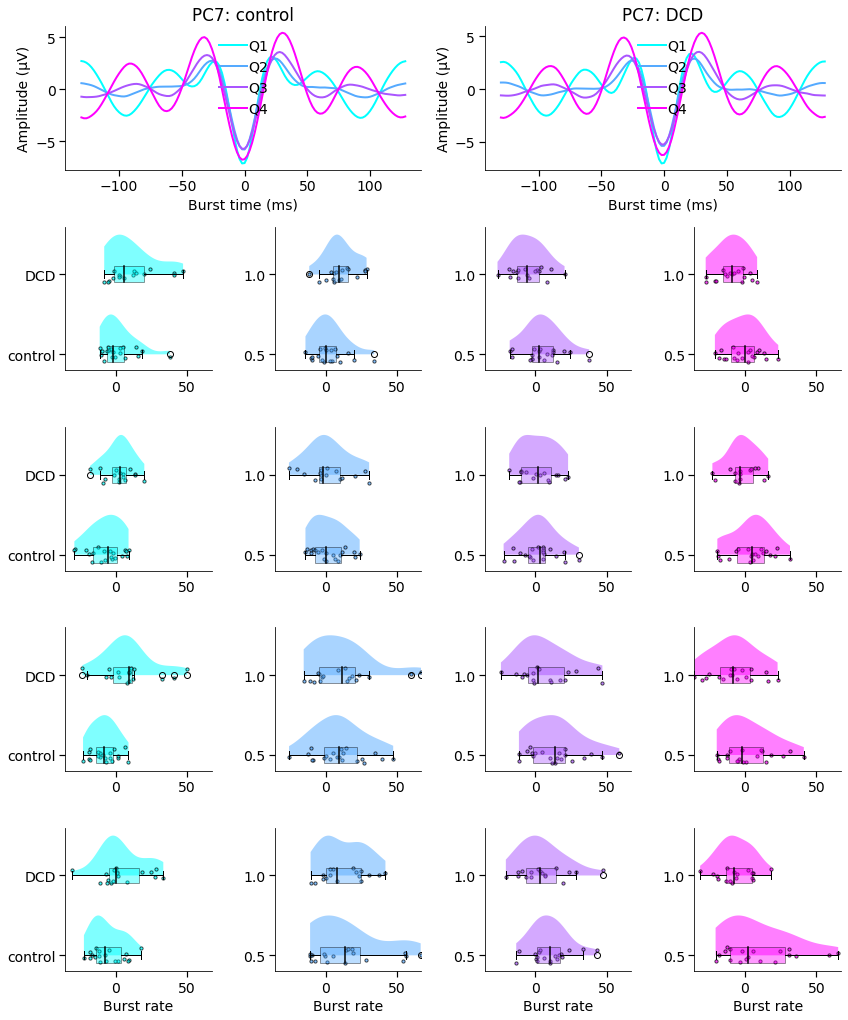

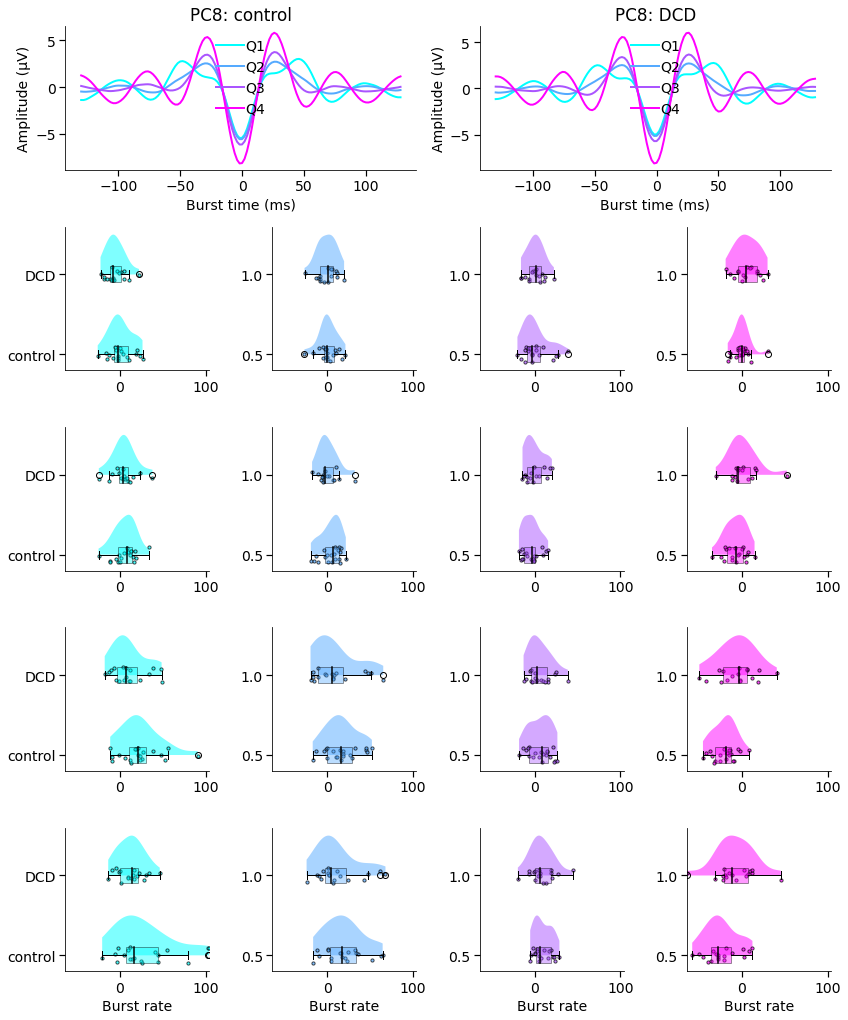

In [102]:
for i in modulated_pcs:
    plot_pc_burst_rate(
        ['obs fine','obs gross','exe fine','exe gross'],
        ['E 17','E 18','E 33','E 34'], 
        10, 
        i, 
        baseline_evt='E  9'
    )

In [103]:
def plot_pc_burst_rate_behav(conditions, events, trial_dur, pc_idx, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'])
    typ_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 0)[0]])
    dcd_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 1)[0]])
    
    step=100/n_pc_bins
    t_bins = np.percentile(pca_components[pc_idx], np.arange(0,100+step,step))
    time_bin_size = .05
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    t_rates_unsmoothed = {}
    avg_rates = {}
    behav_scores = {}
    for condition in conditions:
        t_rates_unsmoothed[condition]={}
        avg_rates[condition]={}
        behav_scores[condition] = {}
        for t in range(n_pc_bins):
            t_rates_unsmoothed[condition][t] = {'typ': [], 'dcd': []}
            avg_rates[condition][t] = {'typ': [], 'dcd': []}
            behav_scores[condition][t] = {'typ': [], 'dcd': []}

    
    for condition, event in zip(conditions, events):
        for subject in subjects:
            group = 'typ' if np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0] == 0 else 'dcd'
            subj_idx = (all_bursts['subject'] == subject)             

            cond_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == event)])
            base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)]) if baseline_evt else []

            if len(cond_trials)>=min_trials_per_cond and (baseline_evt is None or len(base_trials)>=min_trials_per_cond):  

                mabc = df.loc[df['SubjectID'] == subject, 'MABC_TestScore']
                mabc_value = mabc.values[0] if not mabc.empty else np.nan
                

                for t in range(n_pc_bins):
                    t_idx = (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t+1])

                    unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == event) & t_idx], bins=time_bins)
                    unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                    if baseline_evt:
                        unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == baseline_evt) & t_idx], bins=time_bins)
                        unsmoothed_base_rate = (unsmoothed_base_rate / time_bin_size) / len(base_trials)
                        unsmoothed_bc_rate = (unsmoothed_rate - np.mean(unsmoothed_base_rate))/np.mean(unsmoothed_base_rate)*100

                        t_rates_unsmoothed[condition][t][group].append(unsmoothed_bc_rate)

                    else:   
                        t_rates_unsmoothed[condition][t][group].append(unsmoothed_rate)
                    behav_scores[condition][t][group].append(mabc_value) 
                    
        for t in t_rates_unsmoothed[condition]:
            for group in t_rates_unsmoothed[condition][t]:
                t_rates_unsmoothed[condition][t][group] = np.vstack(t_rates_unsmoothed[condition][t][group])
                avg_rates[condition][t][group] = np.nanmean(t_rates_unsmoothed[condition][t][group], axis=1)
                
                # Remove outliers within group based on burst rate
                rates = avg_rates[condition][t][group]
                behav = np.array(behav_scores[condition][t][group])
                mean_val = np.nanmean(rates)
                std_val = np.nanstd(rates)
                keep_idx = (rates > mean_val - 2.5 * std_val) & (rates < mean_val + 2.5 * std_val)

                avg_rates[condition][t][group] = rates[keep_idx]
                behav_scores[condition][t][group] = behav[keep_idx]

    fig = plt.figure(figsize=(12.5, 3*len(conditions))) 
    gs = fig.add_gridspec(len(conditions), n_pc_bins)
    col_r = plt.cm.cool(np.linspace(0, 1, num=n_pc_bins))        

    for c_idx, condition in enumerate(conditions):
        for t in range(n_pc_bins):
            ax = fig.add_subplot(gs[c_idx, t])
            ax.scatter(avg_rates[condition][t]['typ'], behav_scores[condition][t]['typ'],label='control',color=typ_color)
            ax.scatter(avg_rates[condition][t]['dcd'], behav_scores[condition][t]['dcd'],label='DCD',color=dcd_color)
            all_rates=np.hstack([avg_rates[condition][t]['typ'], avg_rates[condition][t]['dcd']])
            all_behav_scores=np.hstack([behav_scores[condition][t]['typ'], behav_scores[condition][t]['dcd']])
            rho, pval = spearmanr(all_rates, all_behav_scores)
            if pval<0.05:
                print(f'{condition} PC{pc_idx+1} T{t+1}: all rho={rho:.2f}, p={pval:.3f}')
                for group in ['typ','dcd']:
                    g_rho, g_pval = spearmanr(avg_rates[condition][t][group], behav_scores[condition][t][group])
                    print(f'{condition} PC{pc_idx+1} T{t+1}: {group} rho={g_rho:.2f}, p={g_pval:.3f}')

            # Linear regression
            slope, intercept, r_value, p_value, std_err = linregress(all_rates, all_behav_scores)

            # Generate regression line
            x_fit = np.linspace(np.min(all_rates), np.max(all_rates), 100)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, color=col_r[t,:])

            # Bootstrapping for confidence intervals
            y_fit_lower, y_fit_upper = bootstrap_regression_ci(all_rates, all_behav_scores, x_fit)

            # Confidence interval shading
            ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color=col_r[t,:], alpha=0.3)
            if c_idx==len(conditions)-1:
                ax.set_xlabel('Burst rate')
            if t==0:
                ax.set_ylabel('Behav')
            if t==n_pc_bins-1 and c_idx==0:
                plt.legend()            

    plt.tight_layout()
    plt.savefig(f'./manuscript/figx_pc_burst_rate_pc_{pc_idx+1}_behav.pdf')

obs fine PC7 T1: all rho=-0.32, p=0.041
obs fine PC7 T1: typ rho=0.05, p=0.806
obs fine PC7 T1: dcd rho=-0.51, p=0.035
obs fine PC7 T2: all rho=-0.41, p=0.008
obs fine PC7 T2: typ rho=-0.11, p=0.614
obs fine PC7 T2: dcd rho=-0.53, p=0.029
obs fine PC7 T3: all rho=0.34, p=0.026
obs fine PC7 T3: typ rho=0.12, p=0.553
obs fine PC7 T3: dcd rho=-0.01, p=0.978
obs fine PC7 T4: all rho=0.34, p=0.028
obs fine PC7 T4: typ rho=0.13, p=0.527
obs fine PC7 T4: dcd rho=0.31, p=0.220
exe fine PC7 T1: all rho=-0.49, p=0.001
exe fine PC7 T1: typ rho=-0.07, p=0.748
exe fine PC7 T1: dcd rho=-0.08, p=0.757


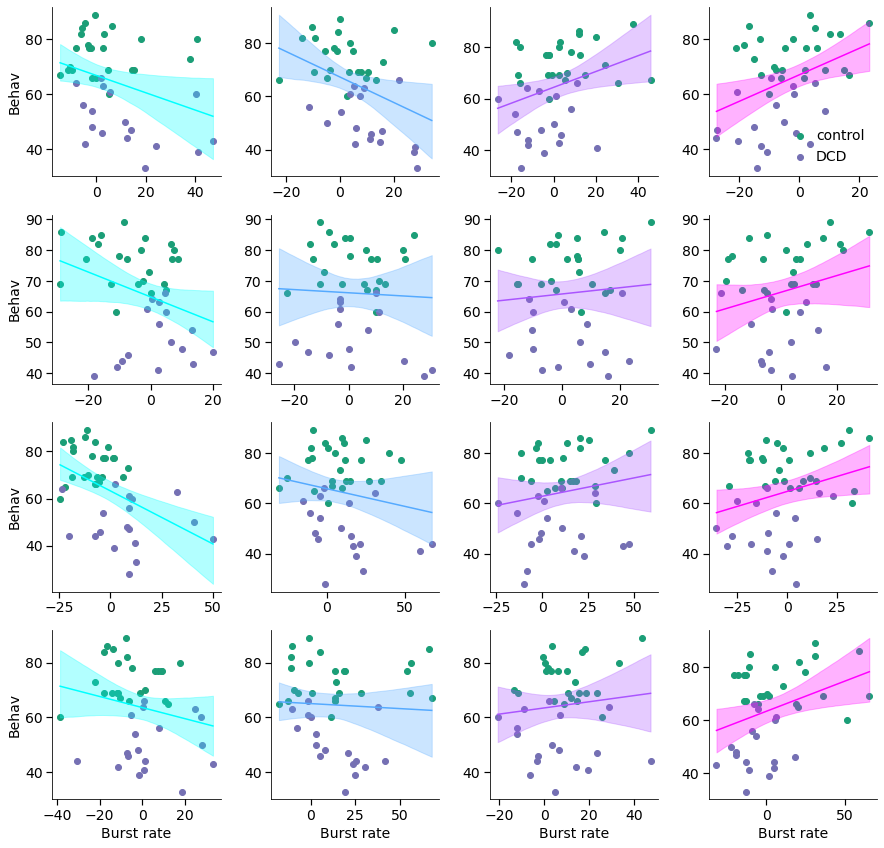

In [104]:
i=6
plot_pc_burst_rate_behav(
    ['obs fine','obs gross','exe fine','exe gross'],
    ['E 17','E 18','E 33','E 34'],
    10, 
    i, 
    baseline_evt='E  9'
)

In [142]:
def analyze_hemi_pc_burst_rate(hemi, conditions, events, trial_dur, pc_idx, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'])
    typ_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 0)[0]])
    dcd_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 1)[0]])
    
    step=100/n_pc_bins
    t_bins = np.percentile(pca_components[pc_idx], np.arange(0,100+step,step))
    time_bin_size = .05
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    t_rates_unsmoothed = {}
    avg_rates = {}
    perm_results = {}
    for condition in conditions:
        t_rates_unsmoothed[condition] = {}
        avg_rates[condition] = {}
        perm_results[condition] = []
        for t in range(n_pc_bins):
            t_rates_unsmoothed[condition][t] = {'typ': [], 'dcd': []}
            avg_rates[condition][t] = {'typ': [], 'dcd': []}
    for condition, event in zip(conditions, events):
        for subject in subjects:
            if ~np.isin(subject, exclude_typ):
                group = 'typ' if np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0] == 0 else 'dcd'
                if hemi=='ipsi' or hemi=='contra':
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['hemi']==hemi)
                elif hemi=='left':
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster']=='C3')
                elif hemi=='right':
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster']=='C4')
                cond_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == event)])
                base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)]) if baseline_evt else []

                if len(cond_trials)>=min_trials_per_cond and (baseline_evt is None or len(base_trials)>=min_trials_per_cond):  
                    for t in range(n_pc_bins):
                        t_idx = (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t+1])
                        if np.sum(subj_idx & (all_bursts['condition'] == event) & t_idx):
                            unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == event) & t_idx], bins=time_bins)
                            unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                            if baseline_evt:
                                unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == baseline_evt) & t_idx], bins=time_bins)
                                unsmoothed_base_rate = (unsmoothed_base_rate / time_bin_size) / len(base_trials)
                                unsmoothed_bc_rate = (unsmoothed_rate - np.nanmean(unsmoothed_base_rate))/np.nanmean(unsmoothed_base_rate)*100

                                t_rates_unsmoothed[condition][t][group].append(unsmoothed_bc_rate)

                            else:   
                                t_rates_unsmoothed[condition][t][group].append(unsmoothed_rate)
                    
        for t in t_rates_unsmoothed[condition]:
            for group in t_rates_unsmoothed[condition][t]:
                t_rates_unsmoothed[condition][t][group] = np.vstack(t_rates_unsmoothed[condition][t][group])#[:, idx]
                avg_rates[condition][t][group] = np.nanmean(t_rates_unsmoothed[condition][t][group], axis=1)

                group_data = avg_rates[condition][t][group]
                mean_val = np.nanmean(group_data)
                std_val = np.nanstd(group_data)
                keep_idx = (group_data > mean_val - 2.5 * std_val) & (group_data < mean_val + 2.5 * std_val)

                avg_rates[condition][t][group] = group_data[keep_idx]
                t_rates_unsmoothed[condition][t][group] = t_rates_unsmoothed[condition][t][group][keep_idx]

            diff, p_value = permutation_test(avg_rates[condition][t]['typ'], avg_rates[condition][t]['dcd'])
            perm_results[condition].append(p_value)
            if p_value < 0.05:
                m_typ=np.mean(avg_rates[condition][t]['typ'])
                sd_typ=np.std(avg_rates[condition][t]['typ'])
                m_dcd=np.mean(avg_rates[condition][t]['dcd'])
                sd_dcd=np.std(avg_rates[condition][t]['dcd'])
                print(f"PC{pc_idx+1} Q{t+1} {hemi} {condition}: Mcontrol = {m_typ:.2f}, SD = {sd_typ:.2f} %, MDCD = {m_dcd:.2f}, SD = {sd_dcd:.2f} %, p = {p_value:.3f}")
    
    # Convert to DataFrame
    data = []
    for condition, bins in avg_rates.items():
        for pc_bin, groups in bins.items():
            subj_idx=0
            for group, rates in groups.items():
                for rate in rates:
                    data.append([subj_idx, group, condition, pc_bin, rate])
                    subj_idx+=1

    df = pd.DataFrame(data, columns=["subject_idx", "group", "condition", "pc_bin", "rate"])
    df.to_csv(f'./data/derivatives/{pipeline}/pc_{pc_idx+1}_rates_{hemi}.csv')
    
    
def analyze_hemi_pc_burst_rate_all_conds(hemi, conditions, events, trial_dur, pc_idx, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'])
    typ_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 0)[0]])
    dcd_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 1)[0]])
    
    step=100/n_pc_bins
    t_bins = np.percentile(pca_components[pc_idx], np.arange(0,100+step,step))
    time_bin_size = .05
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    t_rates_unsmoothed = {}
    avg_rates = {}
    perm_results = []
    for t in range(n_pc_bins):
        t_rates_unsmoothed[t] = {'typ': [], 'dcd': []}
        avg_rates[t] = {'typ': [], 'dcd': []}
    for subject in subjects:
        if ~np.isin(subject, exclude_typ):
            group = 'typ' if np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0] == 0 else 'dcd'
            if hemi=='ipsi' or hemi=='contra':
                subj_idx = (all_bursts['subject'] == subject) & (all_bursts['hemi']==hemi)
            elif hemi=='left':
                subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster']=='C3')
            elif hemi=='right':
                subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster']=='C4')
            cond_trials = np.unique(all_bursts['trial'][subj_idx & (np.isin(all_bursts['condition'], events))])
            base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)]) if baseline_evt else []

            if len(cond_trials)>=min_trials_per_cond and (baseline_evt is None or len(base_trials)>=min_trials_per_cond):  
                for t in range(n_pc_bins):
                    t_idx = (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t+1])
                    if np.sum(subj_idx & (np.isin(all_bursts['condition'], events)) & t_idx):
                        unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (np.isin(all_bursts['condition'], events)) & t_idx], bins=time_bins)
                        unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                        if baseline_evt:
                            unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == baseline_evt) & t_idx], bins=time_bins)
                            unsmoothed_base_rate = (unsmoothed_base_rate / time_bin_size) / len(base_trials)
                            unsmoothed_bc_rate = (unsmoothed_rate - np.nanmean(unsmoothed_base_rate))/np.nanmean(unsmoothed_base_rate)*100

                            t_rates_unsmoothed[t][group].append(unsmoothed_bc_rate)

                        else:   
                            t_rates_unsmoothed[t][group].append(unsmoothed_rate)

    for t in t_rates_unsmoothed:
        for group in t_rates_unsmoothed[t]:
            t_rates_unsmoothed[t][group] = np.vstack(t_rates_unsmoothed[t][group])#[:, idx]
            avg_rates[t][group] = np.nanmean(t_rates_unsmoothed[t][group], axis=1)

            group_data = avg_rates[t][group]
            mean_val = np.nanmean(group_data)
            std_val = np.nanstd(group_data)
            keep_idx = (group_data > mean_val - 2.5 * std_val) & (group_data < mean_val + 2.5 * std_val)

            avg_rates[t][group] = group_data[keep_idx]
            t_rates_unsmoothed[t][group] = t_rates_unsmoothed[t][group][keep_idx]

        diff, p_value = permutation_test(avg_rates[t]['typ'], avg_rates[t]['dcd'])
        perm_results.append(p_value)
        if p_value < 0.05:
            m_typ=np.mean(avg_rates[t]['typ'])
            sd_typ=np.std(avg_rates[t]['typ'])
            m_dcd=np.mean(avg_rates[t]['dcd'])
            sd_dcd=np.std(avg_rates[t]['dcd'])
            print(f"PC{pc_idx+1} Q{t+1} {hemi}: Mcontrol = {m_typ:.2f}, SD = {sd_typ:.2f} %, MDCD = {m_dcd:.2f}, SD = {sd_dcd:.2f} %, p = {p_value:.3f}")
    
    
    
    

In [106]:
i=6
for hemi in ['ipsi','contra']:
    analyze_hemi_pc_burst_rate(
        hemi,
        ['obs fine','obs gross','exe fine','exe gross'],
        ['E 17','E 18','E 33','E 34'],
        10, 
        i, 
        baseline_evt='E  9'
    )

PC7 Q2 ipsi obs fine: Mcontrol = -5.01, SD = 16.37 %, MDCD = 9.50, SD = 11.94 %, p = 0.006
PC7 Q3 ipsi obs fine: Mcontrol = 3.33, SD = 16.49 %, MDCD = -11.29, SD = 16.91 %, p = 0.016
PC7 Q4 ipsi obs fine: Mcontrol = -0.76, SD = 13.41 %, MDCD = -10.49, SD = 6.65 %, p = 0.014
PC7 Q1 ipsi obs gross: Mcontrol = -7.26, SD = 18.91 %, MDCD = 6.00, SD = 10.43 %, p = 0.020
PC7 Q1 ipsi exe fine: Mcontrol = -6.73, SD = 13.31 %, MDCD = 10.05, SD = 19.52 %, p = 0.004
PC7 Q4 ipsi exe fine: Mcontrol = 3.04, SD = 23.74 %, MDCD = -12.47, SD = 19.97 %, p = 0.042
PC7 Q1 ipsi exe gross: Mcontrol = -9.60, SD = 12.65 %, MDCD = 7.05, SD = 25.99 %, p = 0.019
PC7 Q4 ipsi exe gross: Mcontrol = 12.51, SD = 28.71 %, MDCD = -12.60, SD = 14.27 %, p = 0.002
PC7 Q1 contra exe fine: Mcontrol = -10.96, SD = 12.07 %, MDCD = 4.71, SD = 24.53 %, p = 0.018


In [143]:
i=6
for hemi in ['ipsi','contra']:
    analyze_hemi_pc_burst_rate_all_conds(
        hemi,
        ['obs fine','obs gross','exe fine','exe gross'],
        ['E 17','E 18','E 33','E 34'],
        10, 
        i, 
        baseline_evt='E  9'
    )

PC7 Q1 ipsi: Mcontrol = -5.86, SD = 11.54 %, MDCD = 6.54, SD = 14.25 %, p = 0.005
PC7 Q4 ipsi: Mcontrol = 5.01, SD = 16.90 %, MDCD = -10.42, SD = 9.48 %, p = 0.002


In [107]:
def paired_bootstrap_test(data1, data2, n_permutations=100000):
    """
    Performs a paired bootstrap test to evaluate the significance of the difference between two dependent samples.
    
    Parameters:
        data1 (array-like): First set of paired observations.
        data2 (array-like): Second set of paired observations.
        n_permutations (int): Number of bootstrap resamples to perform.
    
    Returns:
        tuple: (observed difference, p-value)
    """
    # Compute observed difference in means
    diffs = np.array(data1) - np.array(data2)
    obs_diff = np.nanmean(diffs)
    
    # Center differences before resampling
    centered_diffs = diffs - np.nanmean(diffs)
    
    # Perform bootstrap resampling
    perm_diffs = []
    for _ in range(n_permutations):
        resampled_diffs = np.random.choice(centered_diffs, size=len(diffs), replace=True)
        perm_diff = np.nanmean(resampled_diffs)
        perm_diffs.append(perm_diff)
    
    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.nanmean(np.abs(perm_diffs) >= np.abs(obs_diff))
    
    return obs_diff, p_value

In [146]:
def plot_hemi_pc_burst_overall_rate(hemis, conditions, events, trial_dur, pc_idx, baseline_evt=None):
    subjects = np.unique(all_bursts['subject'])
    typ_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 0)[0]])
    dcd_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == 1)[0]])
    
    step = 100 / n_pc_bins
    t_bins = np.percentile(pca_components[pc_idx], np.arange(0, 100 + step, step))
    time_bin_size = .05
    time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

    t_rates_unsmoothed = {}
    avg_rates = {}
    for hemi in hemis:
        t_rates_unsmoothed[hemi] = {}
        avg_rates[hemi] = {}
        for t in range(n_pc_bins):
            t_rates_unsmoothed[hemi][t] = {'typ': [], 'dcd': []}
            avg_rates[hemi][t] = {'typ': [], 'dcd': []}
            
    for hemi in hemis:
        for subject in subjects:
            if ~np.isin(subject, exclude_typ):
                group = 'typ' if np.unique(all_bursts['group'][np.where(all_bursts['subject'] == subject)[0]])[0] == 0 else 'dcd'
                if hemi in ['ipsi', 'contra']:
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['hemi'] == hemi)
                elif hemi == 'left':
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster'] == 'C3')
                elif hemi == 'right':
                    subj_idx = (all_bursts['subject'] == subject) & (all_bursts['cluster'] == 'C4')

                cond_trials = np.unique(all_bursts['trial'][subj_idx & np.isin(all_bursts['condition'], events)])
                base_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == baseline_evt)]) if baseline_evt else []

                if len(cond_trials) >= min_trials_per_cond and (baseline_evt is None or len(base_trials) >= min_trials_per_cond):  
                    for t in range(n_pc_bins):
                        t_idx = (pca_components[pc_idx] >= t_bins[t]) & (pca_components[pc_idx] <= t_bins[t + 1])

                        if np.sum(subj_idx & np.isin(all_bursts['condition'], events) & t_idx):
                            unsmoothed_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & np.isin(all_bursts['condition'], events) & t_idx], bins=time_bins)
                            unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

                            if baseline_evt:
                                unsmoothed_base_rate, _ = np.histogram(all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == baseline_evt) & t_idx], bins=time_bins)
                                unsmoothed_base_rate = (unsmoothed_base_rate / time_bin_size) / len(base_trials)
                                unsmoothed_bc_rate = (unsmoothed_rate - np.mean(unsmoothed_base_rate)) / np.mean(unsmoothed_base_rate) * 100
                                t_rates_unsmoothed[hemi][t][group].append(unsmoothed_bc_rate)
                            else:   
                                t_rates_unsmoothed[hemi][t][group].append(unsmoothed_rate)

    for hemi in hemis:
        for t in range(n_pc_bins):
            for group in ['typ', 'dcd']:
                t_rates_unsmoothed[hemi][t][group] = np.vstack(t_rates_unsmoothed[hemi][t][group])
                avg_rates[hemi][t][group] = np.nanmean(t_rates_unsmoothed[hemi][t][group], axis=1)

    for t in range(n_pc_bins):
        for group in ['typ', 'dcd']:
            x = avg_rates['contra'][t][group]
            y = avg_rates['ipsi'][t][group]
            if len(x) != len(y):
                raise ValueError(f"Length mismatch in paired data for group {group}, tile {t}")
            diffs = x - y
            mean_diff = np.nanmean(diffs)
            std_diff = np.nanstd(diffs)
            keep = (diffs > mean_diff - 2.5 * std_diff) & (diffs < mean_diff + 2.5 * std_diff)
            avg_rates['contra'][t][group] = x[keep]
            avg_rates['ipsi'][t][group] = y[keep]

    for t in range(n_pc_bins):
        for group in ['typ', 'dcd']:
            diff, p_value = paired_bootstrap_test(avg_rates['contra'][t][group], avg_rates['ipsi'][t][group], n_permutations=1000)
            print(f"PC{pc_idx+1} Q{t+1} {group}: Mean Diff = {diff:.3f}, p-value = {p_value:.3f}")

    fig = plt.figure(figsize=(12, 4)) 
    gs = fig.add_gridspec(2, 4)
    col_r = plt.cm.cool(np.linspace(0, 1, num=n_pc_bins))

    min_rate = np.inf
    max_rate = -np.inf
    for hemi in avg_rates:
        for t in avg_rates[hemi]:
            for group in avg_rates[hemi][t]:
                min_rate = min(min_rate, np.min(avg_rates[hemi][t][group]))
                max_rate = max(max_rate, np.max(avg_rates[hemi][t][group]))

    for g_idx, group in enumerate(['typ', 'dcd']):
        for t in range(n_pc_bins):
            ax = fig.add_subplot(gs[g_idx, t])
            data_contra = avg_rates['contra'][t][group]
            data_ipsi = avg_rates['ipsi'][t][group]

            # Boxplots
            bp = ax.boxplot([data_contra, data_ipsi], patch_artist=True, vert=True, widths=0.1, positions=[0.5, 1.0])
            for patch in bp['boxes']:
                patch.set_facecolor(col_r[t, :])
                patch.set_alpha(0.4)
            for median in bp['medians']:
                median.set_color('black')
                median.set_linewidth(1.5)

            # Violin plots (half, outward-facing)
            vp = ax.violinplot([data_contra, data_ipsi], points=500, showmeans=False, showextrema=False, showmedians=False, vert=True)
            for idx, b in enumerate(vp['bodies']):
                verts = b.get_paths()[0].vertices
                x_center = np.mean(verts[:, 0])
                if idx == 0:  # contra: left half
                    verts[:, 0] = np.minimum(verts[:, 0], x_center)
                    verts[:, 0] = 0.5 - (x_center - verts[:, 0])
                else:  # ipsi: right half
                    verts[:, 0] = np.maximum(verts[:, 0], x_center)
                    verts[:, 0] = 1.0 + (verts[:, 0] - x_center)
                b.set_alpha(0.5)
                b.set_facecolor(col_r[t, :])

            # Scatter
            jittered_x_contra = np.full(len(data_contra), 0.5) + np.random.uniform(-0.05, 0.05, len(data_contra))
            jittered_x_ipsi = np.full(len(data_ipsi), 1.0) + np.random.uniform(-0.05, 0.05, len(data_ipsi))
            ax.scatter(jittered_x_contra, data_contra, s=10, color=col_r[t, :], alpha=0.7, edgecolor='black')
            ax.scatter(jittered_x_ipsi, data_ipsi, s=10, color=col_r[t, :], alpha=0.7, edgecolor='black')

            # Connect contra?ipsi pairs
            for i in range(len(data_contra)):
                ax.plot([0.5, 1.0], [data_contra[i], data_ipsi[i]], color='black', alpha=0.5, linewidth=0.5)

            ax.set_xticks([0.5, 1.0])
            if g_idx == 1:
                ax.set_xticklabels(['contra', 'ipsi'])
            else:
                ax.set_xticklabels([])

            ax.set_xlim([0.2, 1.3])
            ax.set_ylim(min_rate-5, max_rate+5)
            if t == 3:
                ax.set_ylabel('Burst rate')

    plt.tight_layout()
    plt.savefig(f'./manuscript/figx_pc_burst_rate_pc_{pc_idx+1}_hemis.pdf')



PC7 Q1 typ: Mean Diff = -0.956, p-value = 0.805
PC7 Q1 dcd: Mean Diff = -4.750, p-value = 0.425
PC7 Q2 typ: Mean Diff = 5.970, p-value = 0.056
PC7 Q2 dcd: Mean Diff = -2.966, p-value = 0.550
PC7 Q3 typ: Mean Diff = -0.439, p-value = 0.925
PC7 Q3 dcd: Mean Diff = 6.077, p-value = 0.210
PC7 Q4 typ: Mean Diff = -2.101, p-value = 0.583
PC7 Q4 dcd: Mean Diff = 7.810, p-value = 0.007


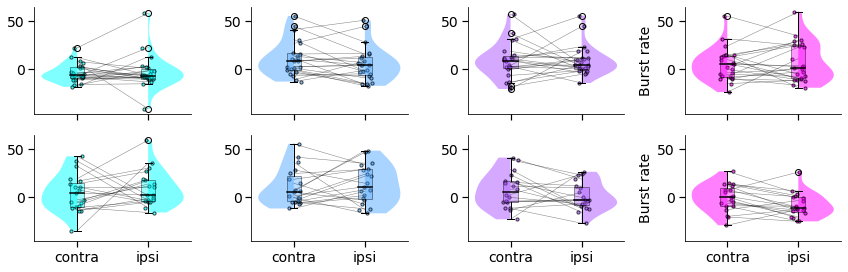

In [147]:
i=6
plot_hemi_pc_burst_overall_rate(
    ['ipsi','contra'],
    ['obs fine','obs gross','exe fine','exe gross'],
    ['E 17','E 18','E 33','E 34'],
    10, 
    i, 
    baseline_evt='E  9'
)